In [1]:
# !pip install brewer2mpl
import numpy as np
import pandas as pd
import math
import random

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings; warnings.filterwarnings(action='once')

large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}

plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline

### Read-in Data

In [2]:
sample = pd.ExcelFile("/Users/ling/Desktop/Interview/DoorDash/03_16_2019/Analytics_Sample_Data.xlsx")
df = sample.parse("Sheet1")

In [3]:
df.head()

,Customer placed order datetime,Placed order with restaurant datetime,Driver at restaurant datetime,Delivered to consumer datetime,Driver ID,Restaurant ID,Consumer ID,Is New,Delivery Region,Is ASAP,Order total,Amount of discount,Amount of tip,Refunded amount
0,14 20:27:45,14 20:29:41,14 20:39:32,14 20:52:03,86,12,5,False,Palo Alto,True,20.45,20.45,3.07,0.0
1,07 20:16:28,07 20:17:32,07 20:36:00,07 20:49:02,325,66,5,False,Palo Alto,True,40.62,40.62,3.73,0.0
2,13 19:35:09,13 19:39:26,13 20:28:16,13 20:52:44,200,124,5,False,Palo Alto,True,37.78,37.78,1.89,0.0
3,22 19:47:53,22 19:56:08,22 20:01:20,22 20:18:01,154,5,14,False,Palo Alto,True,39.66,0.00,1.98,0.0
4,03 19:01:52,03 19:09:08,03 19:36:20,03 19:45:26,332,9,14,False,Palo Alto,True,39.66,0.00,5.95,0.0


In [4]:
df.describe()

,Driver ID,Restaurant ID,Consumer ID,Order total,Amount of discount,Amount of tip,Refunded amount
count,18078.000000,18078.000000,18078.000000,18078.000000,18078.000000,18078.000000,18078.000000
mean,222.448169,108.721263,32010.313475,51.261496,1.356706,3.492022,0.612091
std,105.219194,98.609766,42010.215766,50.599675,6.516667,3.700115,6.073104
min,7.000000,2.000000,5.000000,0.000000,0.000000,0.000000,0.000000
25%,141.000000,23.000000,4243.500000,26.660000,0.000000,1.400000,0.000000
50%,227.000000,77.000000,10972.000000,38.630000,0.000000,2.550000,0.000000
75%,314.000000,186.000000,56857.000000,57.885000,0.000000,4.460000,0.000000
max,438.000000,409.000000,200449.000000,1604.130000,187.880000,120.300000,414.770000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18078 entries, 0 to 18077
Data columns (total 14 columns):
Customer placed order datetime           18078 non-null object
Placed order with restaurant datetime    18038 non-null object
Driver at restaurant datetime            13547 non-null object
Delivered to consumer datetime           18078 non-null object
Driver ID                                18078 non-null int64
Restaurant ID                            18078 non-null int64
Consumer ID                              18078 non-null int64
Is New                                   18078 non-null bool
Delivery Region                          18078 non-null object
Is ASAP                                  18078 non-null bool
Order total                              18078 non-null float64
Amount of discount                       18078 non-null float64
Amount of tip                            18078 non-null float64
Refunded amount                          18078 non-null float64
dtypes: bool

    - Placed order with restaurant datetime has missing values
    - Driver at restaurant datetime has missing values

#### EDA Customer

#### Investigate consumer counts

In [6]:
df['Consumer ID'].nunique()

6701

In [7]:
df.groupby(['Is New'])['Consumer ID'].nunique()

Is New
False    5848
True     2431
Name: Consumer ID, dtype: int64

In [11]:
df.groupby(['Is New'])['Consumer ID'].nunique()/df['Consumer ID'].nunique()

Is New
False    0.872706
True     0.362782
Name: Consumer ID, dtype: float64

In [13]:
df.groupby(['Is ASAP'])['Consumer ID'].nunique()

Is ASAP
False    1847
True     5829
Name: Consumer ID, dtype: int64

In [14]:
df.groupby(['Is ASAP'])['Consumer ID'].nunique()/df['Consumer ID'].nunique()

Is ASAP
False    0.275631
True     0.869870
Name: Consumer ID, dtype: float64

In [9]:
df.groupby(['Delivery Region'])['Consumer ID'].nunique()

Delivery Region
Mountain View    1352
None                6
Palo Alto        4114
San Jose         1300
Name: Consumer ID, dtype: int64

In [10]:
df.groupby(['Delivery Region'])['Consumer ID'].nunique()/6701

Delivery Region
Mountain View    0.201761
None             0.000895
Palo Alto        0.613938
San Jose         0.194001
Name: Consumer ID, dtype: float64

#### Investigate consumer order frequncy

In [23]:
freq=df.groupby(['Consumer ID']).size().reset_index(name="Orders")

In [25]:
freq['Orders'].describe()

count    6701.000000
mean        2.697806
std         3.301765
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max        66.000000
Name: Orders, dtype: float64

In [40]:
freq2 = df.groupby(['Is New','Consumer ID']).size().reset_index(name='Orders')
freq2.groupby(['Is New'])['Orders'].describe()

,count,mean,std,min,25%,50%,75%,max
Is New,,,,,,,,
False,5848.0,2.490766,3.017635,1.0,1.0,1.0,3.0,54.0
True,2431.0,1.444673,0.938502,1.0,1.0,1.0,2.0,12.0


In [48]:
from scipy import stats

new = freq2[freq2['Is New']==True]['Orders']
exist = freq2[freq2['Is New']==False]['Orders']
print(stats.bartlett(new, exist))
print(stats.ttest_ind(new, exist, equal_var=False))

BartlettResult(statistic=3125.2501700003704, pvalue=0.0)
Ttest_indResult(statistic=-23.87712830698053, pvalue=1.0534531820658834e-121)


In [41]:
freq3 = df.groupby(['Is ASAP','Consumer ID']).size().reset_index(name='Orders')
freq3.groupby(['Is ASAP'])['Orders'].describe()

,count,mean,std,min,25%,50%,75%,max
Is ASAP,,,,,,,,
False,1847.0,1.972388,2.647756,1.0,1.0,1.0,2.0,44.0
True,5829.0,2.476411,2.807970,1.0,1.0,1.0,3.0,60.0


In [50]:
freq4 = df.groupby(['Delivery Region','Consumer ID']).size().reset_index(name='Orders')
freq4.groupby(['Delivery Region'])['Orders'].describe()

,count,mean,std,min,25%,50%,75%,max
Delivery Region,,,,,,,,
Mountain View,1352.0,2.781065,3.339554,1.0,1.0,2.0,3.0,43.0
None,6.0,4.333333,8.164966,1.0,1.0,1.0,1.0,21.0
Palo Alto,4114.0,2.779047,3.501177,1.0,1.0,1.0,3.0,65.0
San Jose,1300.0,2.199231,2.204237,1.0,1.0,1.0,3.0,22.0


#### Investigate consumer order total

In [106]:
def print_out(df):
    total = df.groupby(['Consumer ID']).size().reset_index(name='Orders')
    total2 = df.groupby(['Consumer ID'])['Order total'].sum().reset_index(name='Total Order total')
    del total2['Consumer ID']
    total3 = df.groupby(['Consumer ID'])['Order total'].mean().reset_index(name='Avg Order total')
    del total3['Consumer ID']
    
    total4 = df.groupby(['Consumer ID'])['Amount of discount'].sum().reset_index(name='Total Amount of discount')
    del total4['Consumer ID']
    total5 = df.groupby(['Consumer ID'])['Amount of discount'].mean().reset_index(name='Avg Amount of discount')
    del total5['Consumer ID']
    
    total6 = df.groupby(['Consumer ID'])['Amount of tip'].sum().reset_index(name='Total Amount of tip')
    del total6['Consumer ID']
    total7 = df.groupby(['Consumer ID'])['Amount of tip'].mean().reset_index(name='Avg Amount of tip')
    del total7['Consumer ID']
    
    total8 = df.groupby(['Consumer ID'])['Refunded amount'].sum().reset_index(name='Total Refunded amount')
    del total8['Consumer ID']
    total9 = df.groupby(['Consumer ID'])['Refunded amount'].mean().reset_index(name='Avg Refunded amount')
    del total9['Consumer ID']
    
    merged=pd.concat([total,total2, total3, total4, total5, total6, total7, total8, total9], axis=1)
    return merged

In [110]:
total = print_out(df); 
total.describe()

,Consumer ID,Orders,Total Order total,Avg Order total,Total Amount of discount,Avg Amount of discount,Total Amount of tip,Avg Amount of tip,Total Refunded amount,Avg Refunded amount
count,6701.000000,6701.000000,6701.000000,6701.000000,6701.000000,6701.000000,6701.000000,6701.000000,6701.000000,6701.000000
mean,47501.532010,2.697806,138.293588,50.996381,3.660131,2.210674,9.420798,3.335010,1.651304,0.597639
std,52807.303384,3.301765,282.993680,55.351639,64.214734,4.651552,18.628346,3.489987,10.817367,4.833395
min,5.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6681.000000,1.000000,37.520000,28.306000,0.000000,0.000000,2.040000,1.470000,0.000000,0.000000
50%,14409.000000,1.000000,69.030000,39.660000,0.000000,0.000000,4.400000,2.556667,0.000000,0.000000
75%,83855.000000,3.000000,145.210000,56.570000,6.000000,6.000000,9.700000,4.260000,0.000000,0.000000
max,200449.000000,66.000000,9966.410000,1604.130000,5228.590000,156.000000,433.500000,94.430000,479.080000,226.840000


In [111]:
total1 = print_out(df[df['Is New']==True]); 
total1.describe()

,Consumer ID,Orders,Total Order total,Avg Order total,Total Amount of discount,Avg Amount of discount,Total Amount of tip,Avg Amount of tip,Total Refunded amount,Avg Refunded amount
count,2431.000000,2431.000000,2431.000000,2431.000000,2431.000000,2431.000000,2431.000000,2431.000000,2431.000000,2431.000000
mean,45829.152201,1.444673,75.545302,52.331939,2.193937,1.706341,5.032476,3.465804,0.864677,0.605791
std,49554.467500,0.938502,95.147337,57.373239,17.139977,3.594351,6.833705,3.983314,6.827896,5.812870
min,15.000000,1.000000,8.420000,8.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6064.500000,1.000000,31.450000,27.750000,0.000000,0.000000,1.660000,1.435000,0.000000,0.000000
50%,17197.000000,1.000000,49.380000,39.630000,0.000000,0.000000,3.190000,2.580000,0.000000,0.000000
75%,80651.500000,2.000000,82.610000,57.620000,6.000000,3.000000,5.925000,4.380000,0.000000,0.000000
max,199819.000000,12.000000,1258.840000,1024.200000,827.150000,68.929167,112.010000,79.170000,226.840000,226.840000


In [112]:
total1 = print_out(df[df['Is New']==False]); 
total1.describe()

,Consumer ID,Orders,Total Order total,Avg Order total,Total Amount of discount,Avg Amount of discount,Total Amount of tip,Avg Amount of tip,Total Refunded amount,Avg Refunded amount
count,5848.000000,5848.000000,5848.000000,5848.000000,5848.000000,5848.000000,5848.000000,5848.000000,5848.000000,5848.000000
mean,44393.979651,2.490766,127.061337,49.854345,3.281990,2.015354,8.702945,3.317205,1.532722,0.569408
std,50967.662687,3.017635,263.530085,50.491888,57.953265,4.743476,17.040948,3.325580,10.578464,4.213669
min,5.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6463.750000,1.000000,36.340000,28.190000,0.000000,0.000000,1.987500,1.480000,0.000000,0.000000
50%,13497.500000,1.000000,64.145000,39.570000,0.000000,0.000000,4.145000,2.530000,0.000000,0.000000
75%,80340.500000,3.000000,131.905000,56.137083,6.000000,6.000000,9.000000,4.270000,0.000000,0.000000
max,200449.000000,54.000000,8953.650000,1604.130000,4401.440000,156.000000,389.720000,94.430000,463.370000,122.140000


In [121]:
total2 = print_out(df[df['Is ASAP']==False]); 
total2.describe()

,Consumer ID,Orders,Total Order total,Avg Order total,Total Amount of discount,Avg Amount of discount,Total Amount of tip,Avg Amount of tip,Total Refunded amount,Avg Refunded amount
count,1847.000000,1847.000000,1847.000000,1847.000000,1847.000000,1847.000000,1847.000000,1847.000000,1847.000000,1847.000000
mean,40548.203032,1.972388,158.111148,73.838170,2.062187,1.707510,9.714288,4.384474,2.168614,0.893371
std,49545.275836,2.647756,416.432207,98.450697,8.376029,5.329519,24.057193,5.466778,15.759927,7.672584
min,14.000000,1.000000,8.690000,8.683333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5168.500000,1.000000,36.460000,31.500000,0.000000,0.000000,1.945000,1.590000,0.000000,0.000000
50%,12268.000000,1.000000,65.120000,47.710000,0.000000,0.000000,4.000000,3.000000,0.000000,0.000000
75%,75565.500000,2.000000,132.795000,79.280000,5.000000,1.225000,8.765000,5.336667,0.000000,0.000000
max,200285.000000,44.000000,9569.050000,1604.130000,268.430000,156.000000,417.190000,94.430000,479.080000,226.840000


In [122]:
total3 = print_out(df[df['Is ASAP']==True]); 
total3.describe()

,Consumer ID,Orders,Total Order total,Avg Order total,Total Amount of discount,Avg Amount of discount,Total Amount of tip,Avg Amount of tip,Total Refunded amount,Avg Refunded amount
count,5829.000000,5829.000000,5829.000000,5829.000000,5829.000000,5829.000000,5829.000000,5829.000000,5829.000000,5829.000000
mean,46145.037571,2.476411,108.882148,43.929605,3.554243,2.087189,7.752012,3.031241,1.211179,0.499595
std,51812.875080,2.807970,156.615996,25.509169,65.280200,4.166876,12.765396,2.496283,7.314741,3.445896
min,5.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6570.000000,1.000000,35.380000,27.640000,0.000000,0.000000,1.950000,1.420000,0.000000,0.000000
50%,14122.000000,1.000000,61.920000,38.080000,0.000000,0.000000,4.010000,2.455000,0.000000,0.000000
75%,82498.000000,3.000000,125.260000,52.980000,6.000000,6.000000,8.640000,4.000000,0.000000,0.000000
max,200449.000000,60.000000,4993.830000,385.475000,4960.160000,121.360000,364.130000,46.990000,222.640000,85.920000


In [128]:
ASAP = total2['Avg Order total']
ASAP2 = total3['Avg Order total']
print(stats.bartlett(ASAP, ASAP2))
print(stats.ttest_ind(ASAP, ASAP2, equal_var=False))

BartlettResult(statistic=6281.578713488296, pvalue=0.0)
Ttest_indResult(statistic=12.919310026906649, pvalue=1.1176312921583496e-36)


In [129]:
total4 = print_out(df[df['Delivery Region']=='Mountain View']); 
total4.describe()

,Consumer ID,Orders,Total Order total,Avg Order total,Total Amount of discount,Avg Amount of discount,Total Amount of tip,Avg Amount of tip,Total Refunded amount,Avg Refunded amount
count,1352.000000,1352.000000,1352.000000,1352.000000,1352.000000,1352.000000,1352.000000,1352.000000,1352.000000,1352.000000
mean,45149.497041,2.781065,144.816842,53.245976,2.923299,2.152250,9.910104,3.538146,1.915828,0.873601
std,50890.703039,3.339554,255.135114,62.871695,7.575116,5.472592,17.949961,3.319416,10.623349,7.926387
min,82.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6859.250000,1.000000,40.040000,29.540417,0.000000,0.000000,2.305000,1.590000,0.000000,0.000000
50%,14136.500000,2.000000,71.610000,40.829643,0.000000,0.000000,4.870000,2.717727,0.000000,0.000000
75%,79817.000000,3.000000,153.022500,57.775000,6.000000,4.250000,10.540000,4.470000,0.000000,0.000000
max,200354.000000,43.000000,3830.490000,1024.200000,121.360000,121.360000,233.620000,38.600000,226.840000,226.840000


In [130]:
total5 = print_out(df[df['Delivery Region']=='Palo Alto']); 
total5.describe()

,Consumer ID,Orders,Total Order total,Avg Order total,Total Amount of discount,Avg Amount of discount,Total Amount of tip,Avg Amount of tip,Total Refunded amount,Avg Refunded amount
count,4114.000000,4114.000000,4114.000000,4114.000000,4114.000000,4114.000000,4114.000000,4114.000000,4114.000000,4114.000000
mean,39578.347594,2.779047,145.851770,52.348354,3.676835,1.915692,9.546787,3.311519,1.639421,0.537179
std,50804.358279,3.501177,316.822824,58.803134,80.743350,4.695249,19.511959,3.847135,11.725915,3.874173
min,5.000000,1.000000,7.010000,7.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4759.750000,1.000000,37.495000,28.295000,0.000000,0.000000,2.000000,1.400278,0.000000,0.000000
50%,11051.000000,1.000000,71.740000,39.550000,0.000000,0.000000,4.270000,2.460000,0.000000,0.000000
75%,75235.000000,3.000000,152.847500,57.908750,6.000000,3.000000,9.630000,4.108750,0.000000,0.000000
max,200382.000000,65.000000,9966.410000,1604.130000,5161.810000,156.000000,433.500000,94.430000,479.080000,101.680000


In [132]:
total6 = print_out(df[df['Delivery Region']=='San Jose']); 
total6.describe()

,Consumer ID,Orders,Total Order total,Avg Order total,Total Amount of discount,Avg Amount of discount,Total Amount of tip,Avg Amount of tip,Total Refunded amount,Avg Refunded amount
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000
mean,73748.533846,2.199231,96.188708,43.233945,4.190569,3.237274,7.810554,3.257057,1.274477,0.533872
std,51910.329140,2.204237,118.683910,22.883423,5.597645,3.795925,12.897523,2.458573,6.744683,3.454304
min,1743.000000,1.000000,11.430000,11.430000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19070.000000,1.000000,33.725000,26.926667,0.000000,0.000000,2.000000,1.597500,0.000000,0.000000
50%,76273.000000,1.000000,57.065000,38.747500,6.000000,3.000000,4.165000,2.830000,0.000000,0.000000
75%,99062.250000,3.000000,111.682500,53.311250,6.000000,6.000000,8.682500,4.390000,0.000000,0.000000
max,200449.000000,22.000000,1390.220000,245.430000,149.410000,49.803333,166.160000,25.000000,82.570000,71.760000


In [153]:
total10 = df[df['Delivery Region']!='None'].groupby(['Consumer ID','Delivery Region', 'Is ASAP'])['Order total'].sum().reset_index(name="Order total")
grp_mean = total10.groupby(['Delivery Region', 'Is ASAP'])['Order total'].mean().reset_index(name="Order total")
grp_mean_pivot = grp_mean.pivot(index='Delivery Region', columns='Is ASAP',values='Order total').reset_index()

In [154]:
grp_mean_pivot

Is ASAP,Delivery Region,False,True
0,Mountain View,160.026930,117.087456
1,Palo Alto,168.154105,110.938547
2,San Jose,76.045685,90.294209


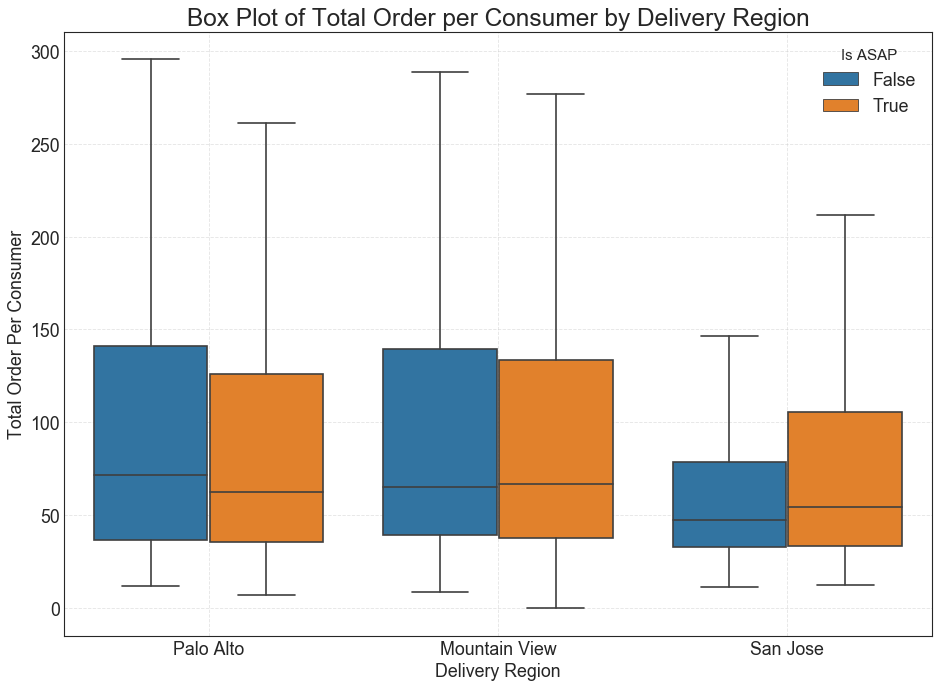

In [157]:
plt.figure(figsize=(14,10), dpi= 80)
sns.boxplot(x='Delivery Region', y='Order total', hue='Is ASAP', data=total10, notch=False, showfliers=False)

# Decorations
plt.gca().set(xlabel='Delivery Region', ylabel='Total Order Per Consumer')
plt.title('Box Plot of Total Order per Consumer by Delivery Region', fontsize=22)
plt.grid(linestyle='--', alpha=0.5)
plt.show()

In [ ]:
 total2 = df.groupby(['Consumer ID'])['Order total'].sum().reset_index(name='Total Order total')

### EDA Restaurants

In [12]:
df['Restaurant ID'].nunique()

314

In [158]:
df.groupby(['Is New'])['Restaurant ID'].nunique()

Is New
False    306
True     245
Name: Restaurant ID, dtype: int64

In [15]:
df.groupby(['Is New'])['Restaurant ID'].nunique()/df['Restaurant ID'].nunique()

Is New
False    0.974522
True     0.780255
Name: Restaurant ID, dtype: float64

In [16]:
df.groupby(['Is ASAP'])['Restaurant ID'].nunique()

Is ASAP
False    255
True     310
Name: Restaurant ID, dtype: int64

In [17]:
df.groupby(['Is ASAP'])['Restaurant ID'].nunique()/df['Restaurant ID'].nunique()

Is ASAP
False    0.812102
True     0.987261
Name: Restaurant ID, dtype: float64

In [160]:
r_freq=df.groupby(['Restaurant ID']).size().reset_index(name="Orders")

In [161]:
r_freq['Orders'].describe()

count    314.000000
mean      57.573248
std       99.284031
min        1.000000
25%        8.000000
50%       24.000000
75%       65.000000
max      747.000000
Name: Orders, dtype: float64

In [162]:
r_freq2 = df.groupby(['Is New','Restaurant ID']).size().reset_index(name='Orders')
r_freq2.groupby(['Is New'])['Orders'].describe()

,count,mean,std,min,25%,50%,75%,max
Is New,,,,,,,,
False,306.0,47.601307,82.410396,1.0,7.0,18.5,50.75,612.0
True,245.0,14.334694,19.881262,1.0,3.0,8.0,18.00,138.0


In [164]:
r_freq3 = df.groupby(['Is ASAP','Restaurant ID']).size().reset_index(name='Orders')
r_freq3.groupby(['Is ASAP'])['Orders'].describe()

,count,mean,std,min,25%,50%,75%,max
Is ASAP,,,,,,,,
False,255.0,14.286275,26.147078,1.0,2.0,6.0,14.5,232.0
True,310.0,46.564516,77.035532,1.0,7.0,20.5,51.0,588.0


In [166]:
r_freq4 = df.groupby(['Delivery Region','Restaurant ID']).size().reset_index(name='Orders')
r_freq4.groupby(['Delivery Region'])['Orders'].describe()

,count,mean,std,min,25%,50%,75%,max
Delivery Region,,,,,,,,
Mountain View,112.0,33.571429,41.649052,1.0,8.0,19.5,40.25,212.0
None,14.0,1.857143,1.099450,1.0,1.0,1.5,2.00,4.0
Palo Alto,149.0,76.731544,130.597930,1.0,5.0,22.0,100.00,744.0
San Jose,156.0,18.326923,26.129495,1.0,3.0,10.0,24.00,186.0


In [167]:
def print_out2(df):
    total = df.groupby(['Restaurant ID']).size().reset_index(name='Orders')
    total2 = df.groupby(['Restaurant ID'])['Order total'].sum().reset_index(name='Total Order total')
    del total2['Restaurant ID']
    total3 = df.groupby(['Restaurant ID'])['Order total'].mean().reset_index(name='Avg Order total')
    del total3['Restaurant ID']
    
    total4 = df.groupby(['Restaurant ID'])['Amount of discount'].sum().reset_index(name='Total Amount of discount')
    del total4['Restaurant ID']
    total5 = df.groupby(['Restaurant ID'])['Amount of discount'].mean().reset_index(name='Avg Amount of discount')
    del total5['Restaurant ID']
    
    total6 = df.groupby(['Restaurant ID'])['Amount of tip'].sum().reset_index(name='Total Amount of tip')
    del total6['Restaurant ID']
    total7 = df.groupby(['Restaurant ID'])['Amount of tip'].mean().reset_index(name='Avg Amount of tip')
    del total7['Restaurant ID']
    
    total8 = df.groupby(['Restaurant ID'])['Refunded amount'].sum().reset_index(name='Total Refunded amount')
    del total8['Restaurant ID']
    total9 = df.groupby(['Restaurant ID'])['Refunded amount'].mean().reset_index(name='Avg Refunded amount')
    del total9['Restaurant ID']
    
    merged=pd.concat([total,total2, total3, total4, total5, total6, total7, total8, total9], axis=1)
    return merged

In [168]:
r_total = print_out2(df); 
r_total.describe()

,Restaurant ID,Orders,Total Order total,Avg Order total,Total Amount of discount,Avg Amount of discount,Total Amount of tip,Avg Amount of tip,Total Refunded amount,Avg Refunded amount
count,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000
mean,201.242038,57.573248,2951.290860,50.888920,78.110000,1.445918,201.047038,3.735527,35.240096,0.791704
std,115.060140,99.284031,5241.968907,29.688132,135.090047,1.280079,344.280360,1.618260,84.077177,3.060747
min,2.000000,1.000000,23.350000,18.560000,0.000000,0.000000,0.790000,0.750000,0.000000,0.000000
25%,99.250000,8.000000,347.905000,39.032098,6.000000,0.583719,27.717500,2.700000,0.000000,0.000000
50%,210.500000,24.000000,1058.500000,48.359714,30.000000,1.171164,82.520000,3.374500,6.780000,0.116886
75%,301.750000,65.000000,3108.317500,57.237235,84.000000,2.000000,228.297500,4.355294,38.580000,0.721420
max,409.000000,747.000000,39374.930000,501.240000,1015.730000,6.000000,2581.520000,13.210800,822.270000,48.790000


In [169]:
r_total1 = print_out2(df[df['Is New']==True]); 
r_total1.describe()

,Restaurant ID,Orders,Total Order total,Avg Order total,Total Amount of discount,Avg Amount of discount,Total Amount of tip,Avg Amount of tip,Total Refunded amount,Avg Refunded amount
count,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000
mean,188.538776,14.334694,749.594408,50.222530,21.769224,1.536531,49.934490,3.614440,8.579714,0.757138
std,114.234065,19.881262,1131.327409,38.194992,34.058271,1.698309,69.936439,1.930253,27.087059,3.866609
min,2.000000,1.000000,14.610000,14.610000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,89.000000,3.000000,110.420000,35.853333,0.000000,0.000000,8.770000,2.347333,0.000000,0.000000
50%,188.000000,8.000000,362.740000,46.240000,6.000000,1.090909,26.310000,3.341111,0.000000,0.000000
75%,292.000000,18.000000,865.010000,57.815800,24.000000,2.400000,66.790000,4.316000,0.000000,0.000000
max,409.000000,138.000000,7729.060000,580.095455,234.000000,6.000000,504.330000,15.230000,291.340000,48.790000


In [171]:
r_total2 = print_out2(df[df['Is New']==False]); 
r_total2.describe()

,Restaurant ID,Orders,Total Order total,Avg Order total,Total Amount of discount,Avg Amount of discount,Total Amount of tip,Avg Amount of tip,Total Refunded amount,Avg Refunded amount
count,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000
mean,197.764706,47.601307,2428.283333,50.490512,62.722484,1.351334,166.322941,3.710450,29.292026,0.627338
std,113.684681,82.410396,4323.079916,27.434513,113.527275,1.239530,286.210151,1.757939,69.527461,1.378942
min,2.000000,1.000000,16.280000,16.280000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,97.250000,7.000000,304.755000,38.752778,6.000000,0.468411,23.820000,2.694542,0.000000,0.000000
50%,206.000000,18.500000,888.640000,48.219552,19.785000,1.125989,67.355000,3.365174,0.000000,0.000000
75%,296.750000,50.750000,2614.932500,57.370900,64.750000,1.950912,184.110000,4.312689,31.967500,0.683138
max,408.000000,612.000000,32294.890000,439.282143,907.730000,6.000000,2077.190000,15.000000,737.440000,13.996667


In [173]:
r_total3 = print_out2(df[df['Is ASAP']==False]); 
r_total3.describe()

,Restaurant ID,Orders,Total Order total,Avg Order total,Total Amount of discount,Avg Amount of discount,Total Amount of tip,Avg Amount of tip,Total Refunded amount,Avg Refunded amount
count,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000
mean,182.980392,14.286275,1145.220745,70.143222,14.936706,1.290446,70.361922,4.689175,15.707569,0.869243
std,109.436655,26.147078,2275.203136,43.524660,26.629010,1.709289,132.711647,2.649975,54.846548,2.794001
min,2.000000,1.000000,14.650000,14.650000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,88.500000,2.000000,122.430000,45.936667,0.000000,0.000000,8.105000,2.963333,0.000000,0.000000
50%,183.000000,6.000000,322.800000,62.574000,6.000000,0.782609,22.970000,4.217143,0.000000,0.000000
75%,271.500000,14.500000,1239.905000,84.118571,16.000000,2.000000,78.175000,5.760000,11.325000,0.564203
max,401.000000,232.000000,18552.520000,501.240000,182.080000,8.428571,1068.120000,18.790000,671.300000,31.540000


In [174]:
total4 = print_out2(df[df['Is ASAP']==True]); 
total4.describe()

,Restaurant ID,Orders,Total Order total,Avg Order total,Total Amount of discount,Avg Amount of discount,Total Amount of tip,Avg Amount of tip,Total Refunded amount,Avg Refunded amount
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,201.574194,46.564516,2047.335613,45.038100,66.831226,1.460691,145.762839,3.446961,22.774065,0.721492
std,115.077177,77.035532,3417.301553,14.036252,118.131239,1.411190,234.825318,1.515456,50.295944,3.094280
min,2.000000,1.000000,16.280000,16.280000,0.000000,0.000000,0.790000,0.750000,0.000000,0.000000
25%,99.250000,7.000000,288.552500,35.518542,6.000000,0.534847,23.152500,2.426993,0.000000,0.000000
50%,211.500000,20.500000,824.730000,43.121429,24.000000,1.150051,59.810000,3.181579,0.000000,0.000000
75%,301.750000,51.000000,2192.255000,52.422159,70.940000,2.000000,162.465000,4.093393,26.732500,0.558247
max,409.000000,588.000000,24061.010000,99.755000,854.010000,7.972571,1620.690000,12.730000,545.080000,48.790000


In [176]:
r_total5 = print_out2(df[df['Delivery Region']=='Mountain View']); 
r_total5.describe()

,Restaurant ID,Orders,Total Order total,Avg Order total,Total Amount of discount,Avg Amount of discount,Total Amount of tip,Avg Amount of tip,Total Refunded amount,Avg Refunded amount
count,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000
mean,149.258929,33.571429,1748.146161,61.002187,35.288393,1.016770,119.629107,3.892892,23.126786,0.644144
std,110.710705,41.649052,2151.992932,68.395258,49.401126,1.384149,147.298848,3.632755,38.869833,1.576546
min,2.000000,1.000000,23.350000,18.560000,0.000000,0.000000,0.790000,0.750000,0.000000,0.000000
25%,52.250000,8.000000,349.285000,40.279000,6.000000,0.269763,26.902500,2.733846,0.000000,0.000000
50%,110.000000,19.500000,1018.350000,51.279286,12.000000,0.686275,70.180000,3.315092,0.000000,0.000000
75%,239.250000,40.250000,2040.125000,58.678566,51.025000,1.264336,154.905000,4.163625,30.287500,0.631745
max,408.000000,212.000000,10710.690000,622.642500,251.910000,10.613333,769.940000,38.600000,237.230000,14.235000


In [179]:
r_total6 = print_out2(df[df['Delivery Region']=='Palo Alto']); 
r_total6.describe()

,Restaurant ID,Orders,Total Order total,Avg Order total,Total Amount of discount,Avg Amount of discount,Total Amount of tip,Avg Amount of tip,Total Refunded amount,Avg Refunded amount
count,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000
mean,137.845638,76.731544,4027.075034,55.340153,101.520134,1.102844,263.593826,3.656325,45.265638,1.509428
std,107.489266,130.597930,6739.139415,39.309230,175.009860,1.223328,441.405935,2.349703,105.311898,8.760413
min,2.000000,1.000000,18.940000,17.572500,0.000000,0.000000,1.280000,0.790000,0.000000,0.000000
25%,49.000000,5.000000,291.740000,39.135263,0.000000,0.000000,20.960000,2.496364,0.000000,0.000000
50%,98.000000,22.000000,1159.380000,48.378667,18.000000,0.928571,80.160000,3.132500,1.080000,0.007171
75%,228.000000,100.000000,5374.820000,59.795446,127.140000,1.522586,362.430000,4.013188,44.280000,0.608030
max,409.000000,744.000000,39173.290000,444.480769,1015.730000,7.774167,2563.580000,18.178462,822.270000,97.580000


In [180]:
r_total7 = print_out2(df[df['Delivery Region']=='San Jose']); 
r_total7.describe()

,Restaurant ID,Orders,Total Order total,Avg Order total,Total Amount of discount,Avg Amount of discount,Total Amount of tip,Avg Amount of tip,Total Refunded amount,Avg Refunded amount
count,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000
mean,258.358974,18.326923,801.572564,48.188057,34.921410,1.763639,65.087949,4.023571,10.620641,0.601981
std,87.274794,26.129495,1192.301546,19.464212,63.104395,1.484290,95.042495,2.503185,21.983774,1.678597
min,15.000000,1.000000,23.350000,18.826667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,175.750000,3.000000,171.920000,36.737206,6.000000,0.666667,13.552500,2.671049,0.000000,0.000000
50%,277.500000,10.000000,448.115000,45.150000,12.000000,1.628993,36.785000,3.489304,0.000000,0.000000
75%,328.250000,24.000000,959.095000,55.223750,36.800000,2.470588,73.887500,4.602892,10.837500,0.342061
max,407.000000,186.000000,9114.110000,165.000000,618.000000,6.000000,727.730000,25.000000,125.140000,14.110000


In [181]:
r_total8 = df[df['Delivery Region']!='None'].groupby(['Restaurant ID','Delivery Region', 'Is ASAP'])['Order total'].mean().reset_index(name="Order total")
grp_mean = total10.groupby(['Delivery Region', 'Is ASAP'])['Order total'].mean().reset_index(name="Order total")
grp_mean_pivot = grp_mean.pivot(index='Delivery Region', columns='Is ASAP',values='Order total').reset_index()

In [182]:
grp_mean_pivot

Is ASAP,Delivery Region,False,True
0,Mountain View,160.026930,117.087456
1,Palo Alto,168.154105,110.938547
2,San Jose,76.045685,90.294209


### EDA Drivers

# df['Driver ID'].nunique()

In [12]:
df2 = df.copy()
df2['Customer placed order datetime fmt'] = df['Customer placed order datetime'].apply(lambda x: datetime.strptime('201901'+ str(x), '%Y%m%d %H:%M:%S').date())
df2['Delivered to consumer datetime fmt'] = df['Delivered to consumer datetime'].apply(lambda x: datetime.strptime('201901'+ str(x), '%Y%m%d %H:%M:%S').hour)
df2['Driver at restaurant datetime fmt'] = df['Driver at restaurant datetime'].apply(lambda x: datetime.strptime('201901'+ str(x), '%Y%m%d %H:%M:%S') if x is not np.nan else None)
df2['Delivered to consumer datetime fmt2'] = df['Delivered to consumer datetime'].apply(lambda x: datetime.strptime('201901'+ str(x), '%Y%m%d %H:%M:%S')) 
df2['gap'] = df2['Delivered to consumer datetime fmt2']-df2['Driver at restaurant datetime fmt']
df2['gap_mins'] = df2['gap'].apply(lambda x: max(0,x.total_seconds()//60))

In [13]:
df2.head(2)

,Customer placed order datetime,Placed order with restaurant datetime,Driver at restaurant datetime,Delivered to consumer datetime,Driver ID,Restaurant ID,Consumer ID,Is New,Delivery Region,Is ASAP,Order total,Amount of discount,Amount of tip,Refunded amount,Customer placed order datetime fmt,Delivered to consumer datetime fmt,Driver at restaurant datetime fmt,Delivered to consumer datetime fmt2,gap,gap_mins
0,14 20:27:45,14 20:29:41,14 20:39:32,14 20:52:03,86,12,5,False,Palo Alto,True,20.45,20.45,3.07,0.0,2019-01-14,20,2019-01-14 20:39:32,2019-01-14 20:52:03,00:12:31,12.0
1,07 20:16:28,07 20:17:32,07 20:36:00,07 20:49:02,325,66,5,False,Palo Alto,True,40.62,40.62,3.73,0.0,2019-01-07,20,2019-01-07 20:36:00,2019-01-07 20:49:02,00:13:02,13.0


In [14]:
ts = df2.groupby(['Customer placed order datetime fmt']).size().reset_index(name='orders')

In [16]:
from fbprophet import Prophet

data = pd.DataFrame({'ds': ts['Customer placed order datetime fmt'],
                    'y': np.log(ts['orders'])})
m = Prophet(yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=False, n_changepoints=0)
m.fit(data)
future = m.make_future_dataframe(periods=1)
forecast = m.predict(future)

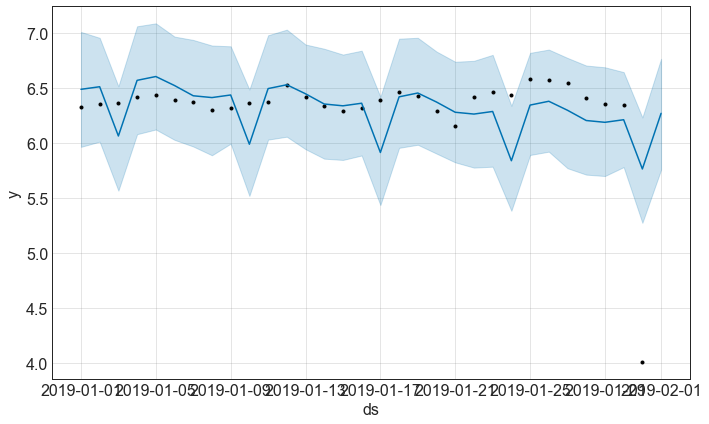

In [18]:
m.plot(forecast)
plt.show()

In [19]:
ts2 = df2.groupby(['Delivered to consumer datetime fmt']).size().reset_index(name='orders')

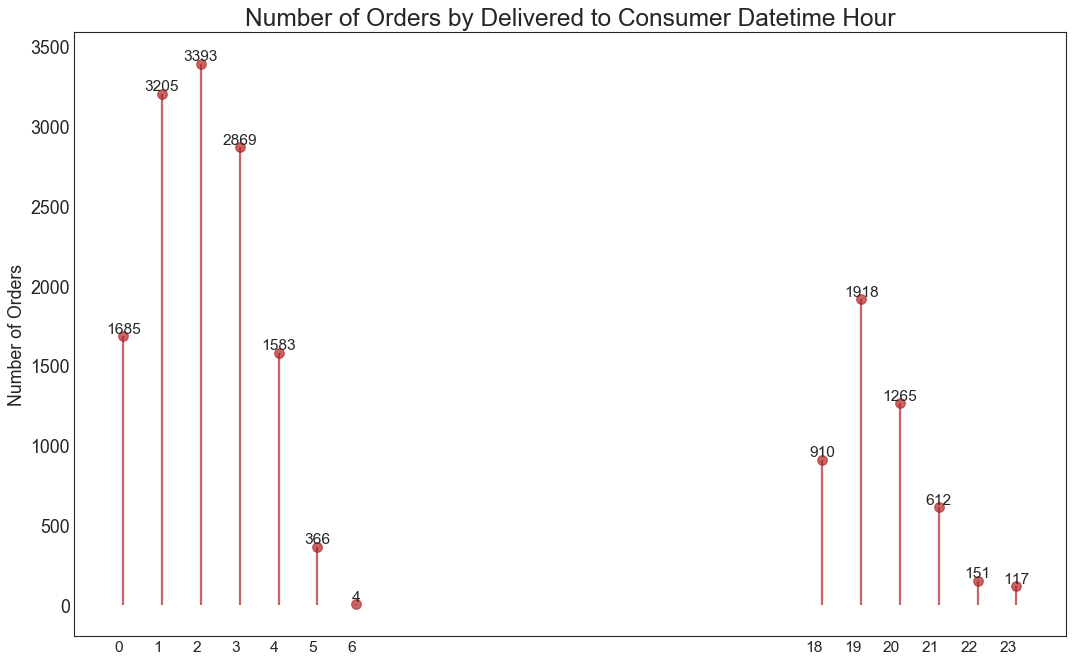

In [20]:
# Draw plot
fig, ax = plt.subplots(figsize=(16,10), dpi= 80)
ax.vlines(x=ts2['Delivered to consumer datetime fmt'], ymin=0, ymax=ts2['orders'], color='firebrick', alpha=0.7, linewidth=2)
ax.scatter(x=ts2['Delivered to consumer datetime fmt'], y=ts2['orders'], s=75, color='firebrick', alpha=0.7)

# Title, Label, Ticks and Ylim
ax.set_title('Number of Orders by Delivered to Consumer Datetime Hour', fontdict={'size':22})
ax.set_ylabel('Number of Orders')
ax.set_xticks(ts2['Delivered to consumer datetime fmt'])
ax.set_xticklabels(ts2['Delivered to consumer datetime fmt'], fontdict={'horizontalalignment': 'right', 'size':14})

# Annotate
for x,y in zip(ts2['Delivered to consumer datetime fmt'], ts2['orders']):
    ax.text(x, y+.5, s=round(y, 2), horizontalalignment= 'center', verticalalignment='bottom', fontsize=14)
    
plt.show()

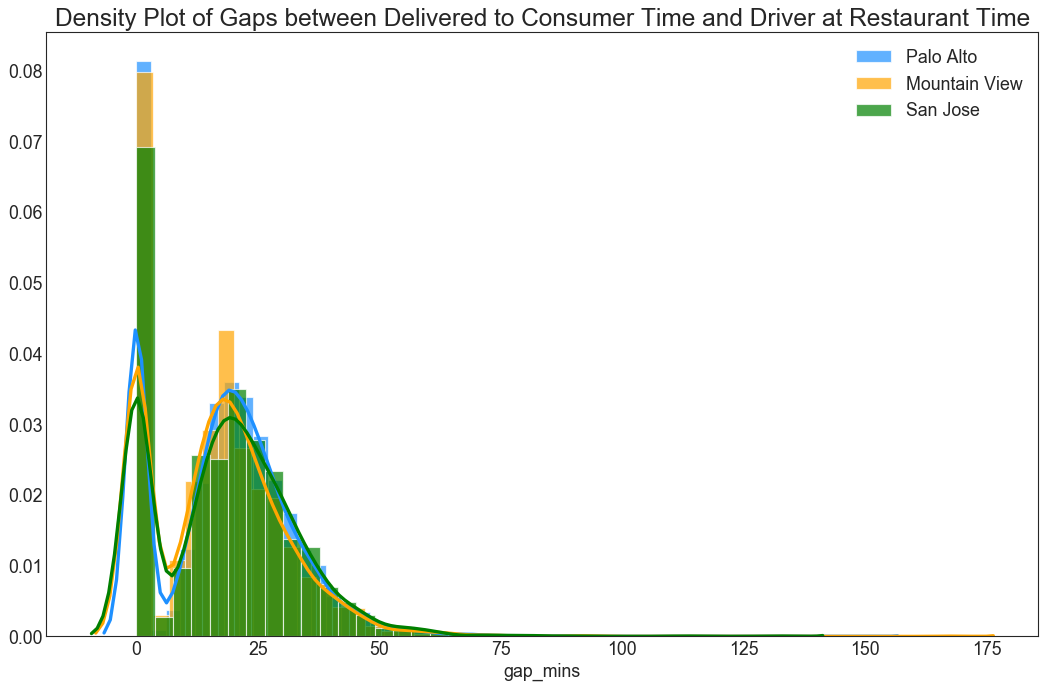

In [21]:
# Draw Plot
plt.figure(figsize=(16,10), dpi= 80)
sns.distplot(df2.loc[(df2['Delivery Region'] == 'Palo Alto') , 'gap_mins'], color="dodgerblue", label="Palo Alto", hist_kws={'alpha':.7}, kde_kws={'linewidth':3})
sns.distplot(df2.loc[(df2['Delivery Region'] == 'Mountain View'), 'gap_mins'], color="orange", label="Mountain View", hist_kws={'alpha':.7}, kde_kws={'linewidth':3})
sns.distplot(df2.loc[(df2['Delivery Region'] == 'San Jose'), 'gap_mins'], color="green", label="San Jose", hist_kws={'alpha':.7}, kde_kws={'linewidth':3})

# Decoration
plt.title('Density Plot of Gaps between Delivered to Consumer Time and Driver at Restaurant Time', fontsize=22)
plt.legend()
plt.show()

In [22]:
df2['gap_mins'].describe()

count    18078.000000
mean        17.759819
std         13.776576
min          0.000000
25%          0.000000
50%         18.000000
75%         26.000000
max        168.000000
Name: gap_mins, dtype: float64

### Sample Size Calculation

In [5]:
# perform power analysis for t-tests
from statsmodels.stats.power import TTestIndPower

# parameters for power analysis
effects = [0.1, 0.15]
alpha = 0.05
power = 0.8

# perform power analysis
def cal_size(effect, alpha, power):
    analysis = TTestIndPower()
    result = analysis.solve_power(effect, power=power, nobs1=None, ratio=1.0, alpha=alpha)
    return result

results = [cal_size(effect, alpha, power) for effect in effects] 

In [6]:
print(results)

[1570.7330663315456, 698.6381616833869]


In [9]:
results[1]*0.8*(2.47-1.97)*(73.84-43.92)

8361.301519026778

In [17]:
df.groupby(['Is ASAP'])['Order total'].sum()

Is ASAP
False    292031.29
True     634674.04
Name: Order total, dtype: float64

In [18]:
8361/292031

0.028630522102105597

In [19]:
df['Order total'].sum()

926705.3300000001

In [20]:
8361/926705

0.009022288646332975

In [25]:
292031.29/926705

0.3151286439589729